<a href="https://colab.research.google.com/github/ash-win19/movies-tv-shows/blob/main/TV_Shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Generate Unique IDs

import pandas as pd

csv_file_path = "TV Shows Masterdata.csv"
df = pd.read_csv(csv_file_path)

df = df.sort_values(by=['Title'], ascending=True)

df['Unique_Group_ID'] = df.groupby('Title').ngroup() + 1

output_file_path = "updated_file.csv"
df.to_csv(output_file_path, index=False)

In [ ]:
# Normalization

import sklearn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/TV Shows Masterdata with UIDs.csv')

# Select the numerical features to normalize
features_to_normalize = ['Episode Duration (in Minutes)', 'Votes', 'Rating']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the selected features
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# View the normalized features
print(df[features_to_normalize])

In [ ]:
# Generate CSV for training the model

import pandas as pd

# Read the dataset
df = pd.read_csv('/content/TV Shows Masterdata with UIDs.csv')

# One-Hot Encode genres
genre_list = set(genre.strip() for sublist in df['Genres'].str.split(',') for genre in sublist)
for genre in genre_list:
    df[genre] = df['Genres'].apply(lambda x: 1 if genre in x else 0)

# Select necessary columns: Include 'Win' column (changed from 'Award_Winner' to 'Win')
columns_to_keep = ['Title', 'Win'] + list(genre_list)  # Keep 'Title', 'Win', and one-hot encoded genre columns
df_selected = df[columns_to_keep]

# Genre Diversity Score - Frequency of each genre combination
genre_combinations = df['Genres'].value_counts()

# Map the diversity score (inverse of frequency)
df['Genre Diversity Score'] = df['Genres'].apply(lambda x: 1 / genre_combinations[x])

# Now, add the 'Genre Diversity Score' to the df_selected DataFrame
df_selected['Genre Diversity Score'] = df['Genre Diversity Score']

# Conversion
df['Win'] = df['Win'].astype(str).str.strip()

# Replace 'TRUE'/'FALSE' with 1/0 (case-insensitive)
df['Win'] = df['Win'].replace({"True": 1, "False": 0}, regex=True)

# If you want to create a dictionary (df_2) and add the 'Win' column to it
df_2 = {'Win': df['Win']}

# Convert df_2 to a DataFrame for easy viewing and display
df_2 = pd.DataFrame(df_2)

# Display the first few rows
df_selected['Win'] = df_2

# Save the selected columns along with the 'Genre Diversity Score' to a new CSV
df_selected.to_csv('Genre Encoded Data with Award Winner.csv', index=False)

<ipython-input-5-f022aa88201c>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Genre Diversity Score'] = df['Genre Diversity Score']
<ipython-input-5-f022aa88201c>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Win'] = df['Win'].replace({"True": 1, "False": 0}, regex=True)
<ipython-input-5-f022aa88201c>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [ ]:
from sklearn.model_selection import train_test_split

# Use this line if the masterdata is inaccessible
#df = pd.read_csv('/content/Genre Encoded Data with Award Winner.csv')

X = df_selected.drop(columns=['Title', 'Win'])  # Features (excluding the target)
y = df_selected['Win']  # Target (whether the movie won an award)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8144475920679887


In [ ]:
# Model Evaluation
from sklearn.metrics import classification_report

# Print classification report for more detailed metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       576
           1       0.33      0.01      0.02       130

    accuracy                           0.81       706
   macro avg       0.57      0.50      0.46       706
weighted avg       0.73      0.81      0.74       706



In [ ]:
# Model improvement
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8158640226628895


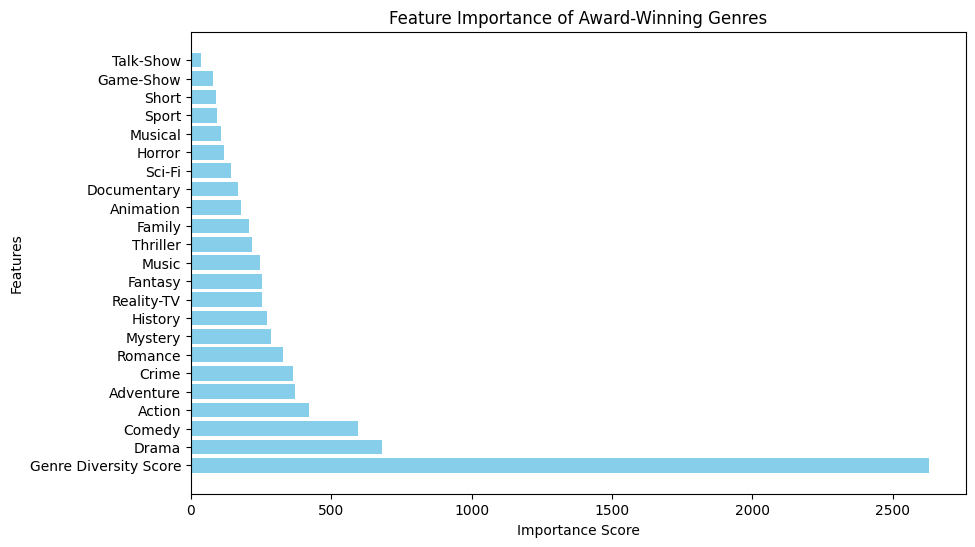

In [ ]:
# Plots !Drop last column!
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Save to CSV for visualization
importance_df.to_csv('feature_importance_genres.csv', index=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance of Award-Winning Genres')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Predict the probability of winning for each movie/show
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probability of winning an award

# Retrieve genre columns (assumed to be one-hot encoded)
genre_columns = X_test.columns.tolist()

# Create a DataFrame with movie/show data and predicted probability
movies_df = pd.DataFrame({
    'Title': X_test.index,  # Assuming index represents the movie/show title or ID
    'Predicted_Probability_Win': y_pred_prob
})

# Extract genre information and map each movie/show to its respective genres
movies_df['Genres'] = X_test.apply(
    lambda row: ', '.join([genre for genre in genre_columns if row[genre] == 1]),
    axis=1
)

# Replace empty genres with "Unknown" or any placeholder
movies_df['Genres'] = movies_df['Genres'].replace('', 'Unknown')

# Save the resulting DataFrame to CSV
movies_df.to_csv("movie_genre_probabilities.csv", index=False)
print("CSV file created successfully: movie_genre_probabilities.csv")


CSV file created successfully: movie_genre_probabilities.csv
